In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

env = UnityEnvironment(file_name="./Tennis.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [2]:
past_scores = []

def maddpg_tennis(agent_0, agent_1):
    global past_scores
    past_scores = []
    scores_deque = deque(maxlen=100)

    for i_episode in range(1, 10000):
        env_info = env.reset(train_mode=True)[brain_name]
        state_0 = env_info.vector_observations[0]
        state_1 = env_info.vector_observations[1]
        states = np.reshape(env_info.vector_observations, (1,48))
        # states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent_0.reset()
        agent_1.reset()
    
        for timestep in range(3000):
            # if i_episode < N:
            #     action_0 = random_action()
            # else:
            action_0 = agent_0.act(states)
            action_1 = agent_1.act(states)
            # print(action_0, action_1)
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            env_info = env.step(actions)[brain_name]

            next_state_0 = env_info.vector_observations[0]
            next_state_1 = env_info.vector_observations[1]
            next_states = np.reshape(env_info.vector_observations, (1, 48))
            # next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += env_info.rewards

            agent_0.step(states, actions, rewards[0], next_states, dones, 0)
            agent_1.step(states, actions, rewards[1], next_states, dones, 1)

            state_0 = next_state_0
            state_1 = next_state_1
            states = next_states
            if np.any(dones):
                break
    
        past_scores.append(np.max(scores))
        scores_deque.append(np.max(scores))
        average_score = np.mean(scores_deque)
        print(f'\rEpisode {i_episode} score: {np.max(scores)}\tAverage Score: {average_score:.2f}', end="")

        # print(agent_0.actor_local.state_dict()["fc1.weight"])
        if i_episode % 100 == 0:
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_agent1_actor.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_agent1_critic.pth')

            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_agent2_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_agent2_critic.pth')

            print(f'\rEpisode {i_episode}\tAverage Score: {average_score:.2f}')

        if average_score >= 0.5:
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_agent1_actor.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_agent1_critic.pth')

            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_agent2_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_agent2_critic.pth')

            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {average_score:.2f}')
            break

agent_0 = Agent(state_size, action_size)
agent_1 = Agent(state_size, action_size)
maddpg_tennis(agent_0, agent_1)

Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.03
Episode 300	Average Score: 0.05
Episode 400	Average Score: 0.05
Episode 500	Average Score: 0.05
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.09
Episode 800	Average Score: 0.12
Episode 900	Average Score: 0.13
Episode 1000	Average Score: 0.16
Episode 1100	Average Score: 0.17
Episode 1200	Average Score: 0.19
Episode 1300	Average Score: 0.25
Episode 1400	Average Score: 0.38
Episode 1500	Average Score: 0.43
Episode 1600	Average Score: 0.46
Episode 1617 score: 0.800000011920929	Average Score: 0.50
Environment solved in 1617 episodes!	Average Score: 0.50


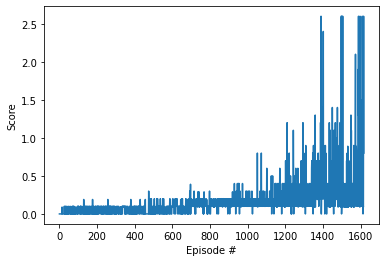

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(past_scores)+1), past_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()